In [1]:
import opendatasets
opendatasets.download('https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition')


100%|██████████| 1.98G/1.98G [11:47<00:00, 3.01MB/s]


In [2]:
dataset_dir = 'Path to your working directory'


In [3]:

import os
for dirname, _, filenames in os.walk('Path to the working directory/fruit-and-vegetable-image-recognition'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report #
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

In [5]:
# Create a list with the filepaths for training and testing
train_dir = Path('./fruit-and-vegetable-image-recognition/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [6]:
test_dir = Path('./fruit-and-vegetable-image-recognition/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [7]:
val_dir = Path('./fruit-and-vegetable-image-recognition/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [8]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures """
    
    print(f"Number of filepaths: {len(filepath)}")
    
    # Create a dataframe with the filepaths and the labels of the pictures
    labels = [str(filepath[i]).split("\\")[-2] for i in range(len(filepath))]
    
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

In [9]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

Number of filepaths: 2855
Number of filepaths: 340
Number of filepaths: 340


In [10]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: ['onion' 'capsicum' 'jalepeno' 'orange' 'tomato' 'pear' 'apple' 'corn'
 'kiwi' 'soy beans' 'pineapple' 'garlic' 'paprika' 'watermelon'
 'bell pepper' 'spinach' 'carrot' 'banana' 'chilli pepper' 'raddish'
 'grapes' 'peas' 'turnip' 'lemon' 'beetroot' 'lettuce' 'pomegranate'
 'eggplant' 'sweetcorn' 'ginger' 'cucumber' 'sweetpotato' 'cabbage'
 'potato' 'cauliflower' 'mango']


In [11]:
train_df.head(5)

,Filepath,Label
0,fruit-and-vegetable-image-recognition\train\on...,onion
1,fruit-and-vegetable-image-recognition\train\ca...,capsicum
2,fruit-and-vegetable-image-recognition\train\ja...,jalepeno
3,fruit-and-vegetable-image-recognition\train\or...,orange
4,fruit-and-vegetable-image-recognition\train\to...,tomato


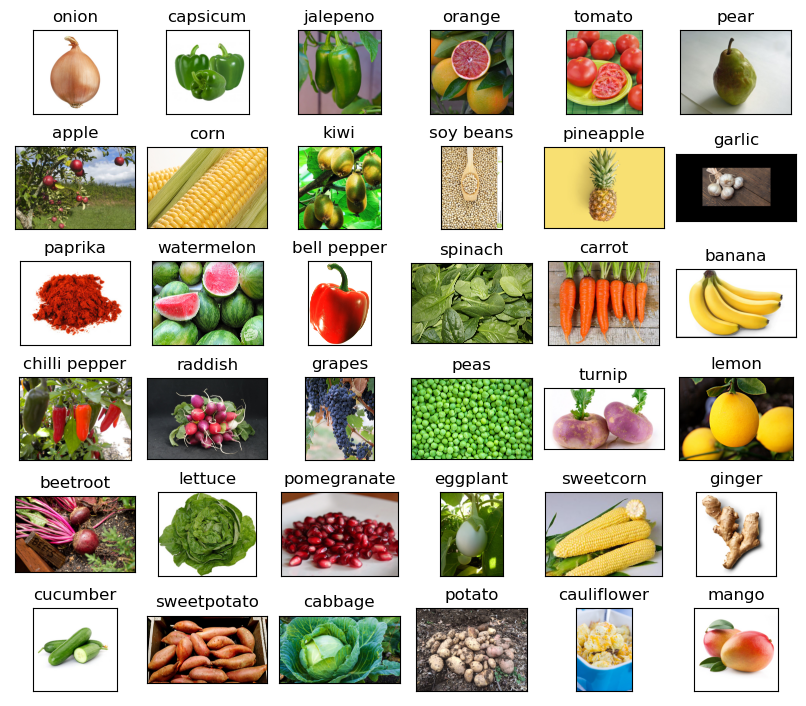

In [12]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [13]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [14]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2855 validated image filenames belonging to 36 classes.


In [15]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 340 validated image filenames belonging to 36 classes.


In [16]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 340 validated image filenames belonging to 36 classes.


In [17]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [18]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
90/90 [==============================] - 580s 6s/step - loss: 1.7796 - accuracy: 0.5282 - val_loss: 0.4845 - val_accuracy: 0.8794
Epoch 2/5
90/90 [==============================] - 552s 6s/step - loss: 0.5690 - accuracy: 0.8221 - val_loss: 0.3531 - val_accuracy: 0.8882
Epoch 3/5
90/90 [==============================] - 468s 5s/step - loss: 0.3629 - accuracy: 0.8841 - val_loss: 0.2674 - val_accuracy: 0.9412
Epoch 4/5
90/90 [==============================] - 620s 7s/step - loss: 0.2256 - accuracy: 0.9285 - val_loss: 0.2413 - val_accuracy: 0.9500
Epoch 5/5
90/90 [==============================] - 553s 6s/step - loss: 0.1598 - accuracy: 0.9517 - val_loss: 0.2029 - val_accuracy: 0.9559


In [19]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images)

11/11 [==============================] - 66s 5s/step - loss: 0.2029 - accuracy: 0.9559


In [20]:
# Predict the label of the test_images
y_true = test_images.labels
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 [==============================] - 85s 8s/step


['paprika',
 'apple',
 'raddish',
 'turnip',
 'jalepeno',
 'turnip',
 'ginger',
 'sweetpotato',
 'tomato',
 'carrot',
 'kiwi',
 'cauliflower',
 'ginger',
 'banana',
 'mango',
 'chilli pepper',
 'lettuce',
 'beetroot',
 'lettuce',
 'lettuce',
 'paprika',
 'pineapple',
 'pear',
 'capsicum',
 'jalepeno',
 'eggplant',
 'jalepeno',
 'sweetpotato',
 'potato',
 'chilli pepper',
 'sweetcorn',
 'tomato',
 'pear',
 'cabbage',
 'ginger',
 'orange',
 'sweetcorn',
 'beetroot',
 'tomato',
 'grapes',
 'cucumber',
 'potato',
 'paprika',
 'garlic',
 'turnip',
 'soy beans',
 'chilli pepper',
 'lemon',
 'ginger',
 'pomegranate',
 'onion',
 'lettuce',
 'paprika',
 'potato',
 'raddish',
 'watermelon',
 'bell pepper',
 'pineapple',
 'peas',
 'watermelon',
 'mango',
 'garlic',
 'beetroot',
 'beetroot',
 'capsicum',
 'sweetcorn',
 'garlic',
 'capsicum',
 'mango',
 'cauliflower',
 'pear',
 'potato',
 'grapes',
 'raddish',
 'mango',
 'potato',
 'onion',
 'cauliflower',
 'peas',
 'spinach',
 'soy beans',
 'onion

In [21]:
# Print the classification report
class_names = list(labels.values())
report = classification_report(y_true, pred, target_names=class_names)
print(report)

# Print the accuracy, precision, recall, and F-measure
print('Test Accuracy:', test_accuracy)

               precision    recall  f1-score   support

        apple       1.00      0.80      0.89        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       1.00      0.78      0.88         9
      cabbage       1.00      1.00      1.00        10
     capsicum       0.83      1.00      0.91        10
       carrot       1.00      1.00      1.00         8
  cauliflower       1.00      1.00      1.00        10
chilli pepper       0.88      1.00      0.93         7
         corn       1.00      0.30      0.46        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         9
     jalepeno       1.00      1.00      1.00         9
         kiwi       1.00      1.00      1.00        10
        l

In [22]:
def output(location):
    img=tf.keras.utils.load_img(location,target_size=(224,224,3))
    img=tf.keras.utils.img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [26]:
model.save('Your working directory/FAV.h5')